In [1]:
# Import all related libraries

import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
# Load Dataset

df = pd.read_csv("UCI_Credit_Card.csv", encoding="utf-8")
df["default.payment.next.month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

From the result above, we note that there is class imbalance.

In [3]:
# Check the feature information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Preprocessing Steps:
1. LIMIT_BAL, all of the BILL_AMT and PAY_AMT, and AGE columns are numeric features, apply StandardScaler. 
2. Repayment status(eg. PAY_0) is ordinal feature, but we don't need to apply OrdinalEncoder since it is already preprocessed. 
3. Sex is binary features and Education, Marriage is a categorical feature, apply OneHotEnconder. 
4. Drop ID column
5. Drop default.payment.next.month (label)

In [5]:
 # 80%-20% train test split on X and y

train_df, test_df = train_test_split(df, test_size=0.2) 

# EDA

In [6]:
# split the labels

no = train_df[train_df["default.payment.next.month"] == 0]
yes = train_df[train_df["default.payment.next.month"] == 1]

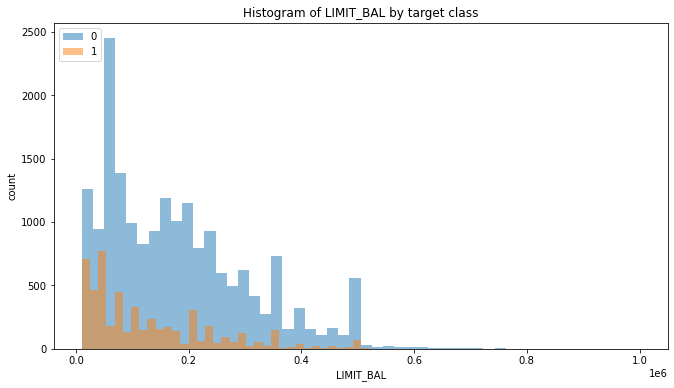

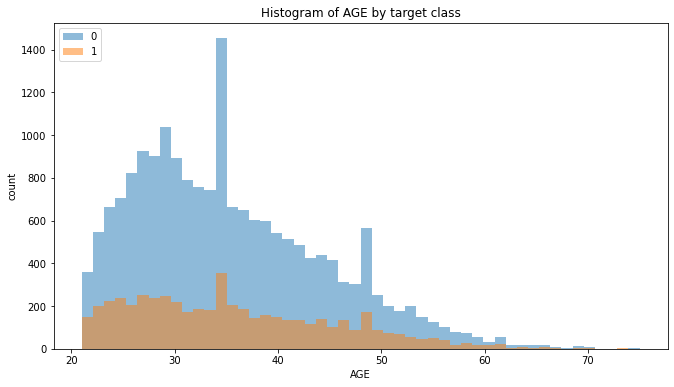

In [7]:
# plot the back-to-back histogram of 2 groups for 2 different columns

cols = ['LIMIT_BAL', 'AGE']

for col in range(len(cols)):
    plt.figure(figsize=(11,6))
    plt.hist(x=cols[col], data=no, label='0', bins=50, alpha=0.5)
    plt.hist(x=cols[col], data=yes, label='1', bins=50, alpha=0.5)
    plt.title('Histogram of {} by target class'.format(cols[col]))
    plt.xlabel(cols[col])
    plt.ylabel('count')
    plt.legend(loc=2)
    plt.show()

1. From the plots above, it is very clear that there is an imbalance issue in the target column.
2. In addition, the LIMIT_BAL plot shows that people who will default the payment are within the 0-0.5 credit range, and within the 0.5-0.6 range, it only contains people who will not default.
3. The Age plot shows that the distribution of "yes" and "no" for default payment is similar. However, within the 25- 30 yrs age range, more people tend to not default payment.

# Preprocessing

In [8]:
# drop the label

target = "default.payment.next.month"
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]
train_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
19476,19477,240000.0,2,2,1,38,0,0,0,0,...,234928.0,160765.0,158184.0,7888.0,8522.0,9260.0,5700.0,5475.0,5520.0,0
24566,24567,300000.0,1,1,2,35,0,0,0,0,...,11890.0,12695.0,13763.0,1510.0,1519.0,2000.0,1005.0,2068.0,0.0,0
10474,10475,60000.0,2,1,2,31,-1,-1,-1,0,...,699.0,0.0,1000.0,11160.0,699.0,0.0,0.0,1430.0,850.0,0
12097,12098,210000.0,2,2,1,32,0,0,0,0,...,134585.0,127282.0,125338.0,6500.0,6500.0,4400.0,5000.0,7000.0,6000.0,0
29462,29463,150000.0,1,1,2,27,0,0,0,0,...,89006.0,89775.0,87725.0,3956.0,4031.0,10006.0,3266.0,4040.0,1698.0,0


In [9]:
# create pipeline to preprocess data

numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2",
                    "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
drop_features = ["ID"]
binary_features = ['SEX']
categorical_features = ['EDUCATION', 'MARRIAGE']
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='if_binary'), binary_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ("drop", drop_features)
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary'), ['SEX']),
                                ('onehotencoder-2',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['EDUCATION', 'MARRIAGE']),
                                ('drop', 'drop', ['ID'])])

# Model Building

In [10]:
scoring_metric = 'f1'
results = dict()

In [11]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [12]:
# Baseline Model

dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric)).mean()

fit_time       0.003601
score_time     0.001800
test_score     0.000000
train_score    0.000000
dtype: float64

In [13]:
# Logistic Regression

logistic_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced'))
pd.DataFrame(cross_validate(logistic_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric)).mean()

fit_time       0.213038
score_time     0.006416
test_score     0.417952
train_score    0.420436
dtype: float64

In [14]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [15]:
# address for class imbalance

ratio_lgbm = list(y_train==0).count(True)/list(y_train==1).count(True)
ratio_cat0 = list(y_train==0).count(True)/len(y_train)
ratio_cat1 = 1-ratio_cat0

In [16]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_dt = DecisionTreeClassifier(class_weight='balanced')
pipe_rf = RandomForestClassifier(class_weight='balanced')
pipe_xgb = XGBClassifier(eval_metric="logloss", verbosity=0, scale_pos_weight=ratio_lgbm)
pipe_lgbm = LGBMClassifier(scale_pos_weight=ratio_lgbm)
pipe_catboost = CatBoostClassifier(verbose=0, class_weights=[ratio_cat0, ratio_cat1])
classifiers = {
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

for (name, model) in classifiers.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.336 (+/- 0.017),0.009 (+/- 0.002),0.328 (+/- 0.012),0.999 (+/- 0.000)
random forest,3.905 (+/- 0.040),0.101 (+/- 0.012),0.253 (+/- 0.013),0.999 (+/- 0.000)
XGBoost,1.752 (+/- 0.311),0.027 (+/- 0.005),0.457 (+/- 0.010),0.740 (+/- 0.006)
LightGBM,0.220 (+/- 0.013),0.020 (+/- 0.000),0.474 (+/- 0.013),0.619 (+/- 0.001)
CatBoost,8.427 (+/- 0.550),0.052 (+/- 0.028),0.060 (+/- 0.005),0.113 (+/- 0.007)


# Hyperparamter Tuning

In [17]:
# XGBoost

from scipy.stats import randint

param_grid_xgb = {
    "xgbclassifier__n_estimators": randint(10, 100),
    "xgbclassifier__learning_rate": [0.01, 0.1]
}

pipe_xgb = make_pipeline(
    preprocessor,
    classifiers["XGBoost"],
)

random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_grid_xgb,
    n_iter=50,
    scoring=scoring_metric,
    return_train_score=True,
)

random_search_xgb.fit(X_train, y_train);

pd.DataFrame(random_search_xgb.cv_results_)[
    [
        "mean_test_score",
        "param_xgbclassifier__n_estimators",
        "param_xgbclassifier__learning_rate",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,7,7,9,10,...,41,42,43,44,44,46,47,48,49,50
mean_test_score,0.472043,0.471884,0.471831,0.471661,0.471187,0.470975,0.470696,0.470696,0.470693,0.470578,...,0.447709,0.445891,0.44504,0.442245,0.442245,0.441909,0.441907,0.441775,0.441663,0.441459
param_xgbclassifier__n_estimators,60,69,61,56,67,65,51,51,74,75,...,31,28,26,14,14,21,17,20,13,15
param_xgbclassifier__learning_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
mean_fit_time,0.808121,0.915242,0.883475,0.762364,0.868383,0.889771,0.67945,0.719211,0.935116,0.982588,...,0.452608,0.425872,0.384365,0.23587,0.233251,0.376906,0.271724,0.317534,0.221396,0.244368


In [18]:
best_pipe_xgb = random_search_xgb.best_estimator_
results['xgb_best'] = mean_std_cross_val_scores(best_pipe_xgb, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.359 (+/- 0.018),0.009 (+/- 0.006),0.326 (+/- 0.007),0.998 (+/- 0.000)
random forest,4.436 (+/- 0.051),0.106 (+/- 0.005),0.253 (+/- 0.021),0.998 (+/- 0.000)
XGBoost,1.253 (+/- 0.014),0.020 (+/- 0.006),0.455 (+/- 0.005),0.738 (+/- 0.004)
LightGBM,0.201 (+/- 0.010),0.019 (+/- 0.001),0.471 (+/- 0.010),0.616 (+/- 0.004)
CatBoost,7.305 (+/- 0.775),0.037 (+/- 0.004),0.064 (+/- 0.013),0.123 (+/- 0.005)
xgb_best,0.832 (+/- 0.034),0.020 (+/- 0.000),0.472 (+/- 0.010),0.580 (+/- 0.004)


In [19]:
# LGBM

pipe_lgbm = make_pipeline(
    preprocessor,
    classifiers["LightGBM"],
)

param_grid_lgbm = {
    'lgbmclassifier__num_leaves': randint(6,50),
    'lgbmclassifier__min_child_samples': randint(100,500),
    'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    scoring=scoring_metric,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__min_child_samples",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,43,43,46,46,46,46,46
mean_test_score,0.476175,0.4754,0.475073,0.474371,0.47414,0.474036,0.473981,0.473909,0.473739,0.473623,...,0.468692,0.467396,0.461659,0.461659,0.461659,0.0,0.0,0.0,0.0,0.0
param_lgbmclassifier__num_leaves,30,32,38,6,40,18,32,37,47,30,...,41,48,23,42,40,37,16,7,11,20
param_lgbmclassifier__min_child_samples,140,432,369,384,309,362,467,387,427,170,...,217,128,154,302,379,380,412,279,238,172
mean_fit_time,0.19328,0.221515,0.215481,0.118301,0.240007,0.165338,0.209582,0.221342,0.20334,0.201419,...,0.230825,0.255061,0.126216,0.124473,0.128247,0.09029,0.076449,0.084265,0.085545,0.082406


In [20]:
best_pipe_lgbm = random_search_lgbm.best_estimator_
results['lgbm_best'] = mean_std_cross_val_scores(best_pipe_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.359 (+/- 0.018),0.009 (+/- 0.006),0.326 (+/- 0.007),0.998 (+/- 0.000)
random forest,4.436 (+/- 0.051),0.106 (+/- 0.005),0.253 (+/- 0.021),0.998 (+/- 0.000)
XGBoost,1.253 (+/- 0.014),0.020 (+/- 0.006),0.455 (+/- 0.005),0.738 (+/- 0.004)
LightGBM,0.201 (+/- 0.010),0.019 (+/- 0.001),0.471 (+/- 0.010),0.616 (+/- 0.004)
CatBoost,7.305 (+/- 0.775),0.037 (+/- 0.004),0.064 (+/- 0.013),0.123 (+/- 0.005)
xgb_best,0.832 (+/- 0.034),0.020 (+/- 0.000),0.472 (+/- 0.010),0.580 (+/- 0.004)
lgbm_best,0.211 (+/- 0.015),0.022 (+/- 0.004),0.476 (+/- 0.005),0.588 (+/- 0.003)


# Model Evaluation

In [23]:
from sklearn.metrics import f1_score

f1_lr = f1_score(y_test, best_pipe_lgbm.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
pipe_rf = RandomForestClassifier(class_weight='balanced')
pipe_rf.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

In [ ]:
pipe_lgbm = LGBMClassifier(scale_pos_weight=ratio_lgbm)
pipe_lgbm.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_lgbm.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

In [ ]:
roc_lr = roc_auc_score(y_test, best_pipe_xgb.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

In [ ]:
pipe_xgb = XGBClassifier(eval_metric="logloss", verbosity=0, scale_pos_weight=ratio_lgbm)
pipe_xgb.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

In [ ]:
pipe_catboost = CatBoostClassifier(verbose=0, class_weights=[ratio_cat0, ratio_cat1])
pipe_catboost.fit(X_train, y_train)
roc_lr = roc_auc_score(y_test, pipe_catboost.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))